# 数据准备

## 数据查看

In [1]:
from pathlib import Path

data_dir = Path('data') # 存放猫猫狗狗的文件夹路径
train_dir = data_dir / 'train'
test_dir = data_dir / 'test1'
train_list = list(train_dir.iterdir())
test_list = list(test_dir.iterdir())
print('train: {}, test: {}'.format(len(train_list), len(test_list)))

train: 25000, test: 12500


cats: 12500, dogs: 12500


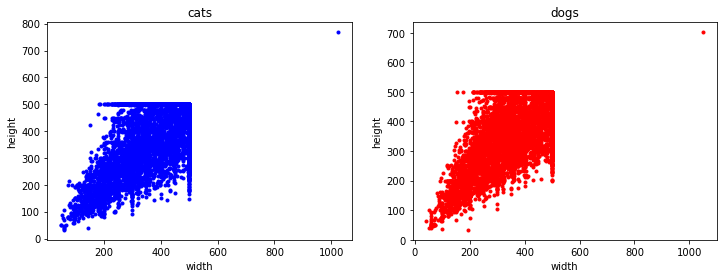

In [2]:
import matplotlib.pyplot as plt
from image_info import jpg_infomation

colors = ['blue', 'red']

heights, widths, channels = [], [], []
cats_heights, cats_widths, cats_channels = [], [], []
dogs_heights, dogs_widths, dogs_channels = [], [], []
cats, dogs = 0, 0
for path in train_list:
    name = path.name
    label = name.split('.')[0]
    h, w, c = jpg_infomation(str(path))
    heights.append(h)
    widths.append(w)
    channels.append(c)
    if label == 'cat':
        cats_heights.append(h)
        cats_widths.append(w)
        cats_channels.append(c)
    elif label == 'dog':
        dogs_heights.append(h)
        dogs_widths.append(w)
        dogs_channels.append(c)
print("cats: {}, dogs: {}".format(len(cats_heights), len(dogs_heights)))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("cats")
plt.xlabel('width')
plt.ylabel('height')
plt.scatter(cats_widths, cats_heights, marker='.', color=colors[0])
plt.subplot(1,2,2)
plt.title("dogs")
plt.xlabel('width')
plt.ylabel('height')
plt.scatter(dogs_widths, dogs_heights, marker='.', color=colors[1])
plt.show()

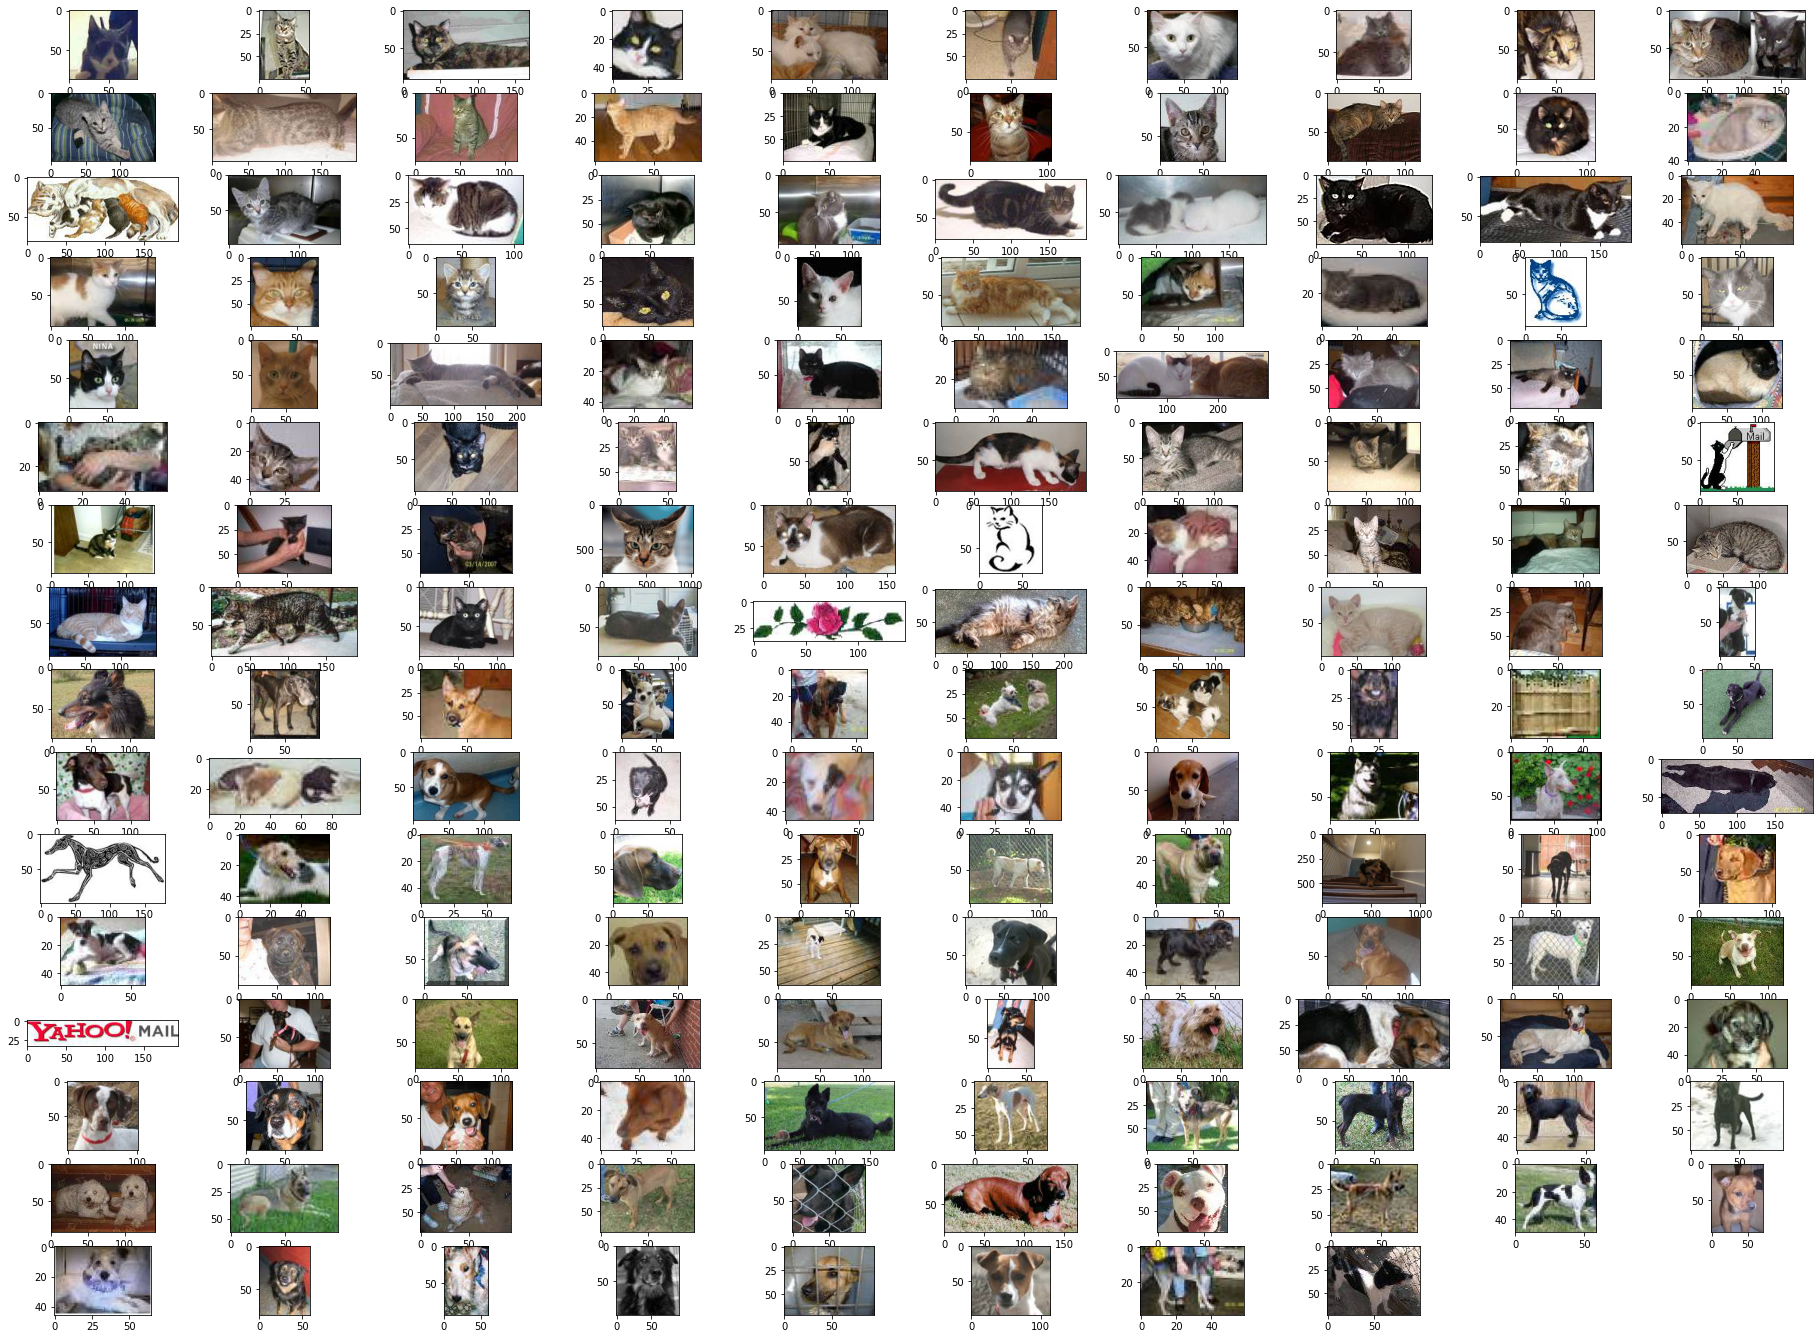

In [3]:
import math
from PIL import Image

outlier = []
for i, height in enumerate(heights):
    if height > 600:
        outlier.append(train_list[i])
    elif height < 100:
        outlier.append(train_list[i])
ncols = 10
nrows = math.ceil(len(outlier) / ncols)
plt.figure(figsize=(32,24))
for i, path in enumerate(outlier, start=1):
    plt.subplot(nrows, ncols, i)
    img_path = str(path)
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
# https://blog.csdn.net/u010099080/article/details/52912439
# 在show之前调用savefig，否则show之后会生成新的figure，导致保存的图像空白
plt.savefig('blog4-2.jpg')
plt.show()

## 定义数据集

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset

In [4]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class DogsCatsSet(Dataset):
    def __init__(self, paths, transform=None, target_transform=None):
        self.paths = paths
        labels = [path.name.split('.')[0] for path in self.paths]
        self.labels = [0 if label == 'cat' else 1 for label in labels]
        self.transform = transform
        self.target_transform = target_transform
        
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img_path = str(self.paths[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

random.shuffle(train_list)
total = len(train_list)
val_size = int(total * 0.2) # 训练验证8:2
val_set = train_list[:val_size]
train_set = train_list[val_size:]
batch_size = 32

transform = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

datasets = {
    'train': DogsCatsSet(train_set, transform['train']),
    'val': DogsCatsSet(val_set, transform['val'])
}

dataset_sizes = {
    'train': len(datasets['train']),
    'val': len(datasets['val'])
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, pin_memory=True),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False, pin_memory=True)
}

# 训练

In [5]:
import time
import copy
from datetime import timedelta

import torch


def train(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, epochs=20):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, epochs+1):
        epoch_since = time.time()
        print('Epoch: {}/{}'.format(epoch, epochs))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_elapsed = time.time() - since
        print("Time: {} / {}".format(timedelta(seconds=time_elapsed), timedelta(seconds=time_elapsed / (epoch / epochs))))
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {}".format(timedelta(seconds=time_elapsed)))
    print("Best Val Acc: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import resnet50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_tf = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model_tf = train(model_ft, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, device, 20)

Epoch: 1/20
----------
train Loss: 0.2232 Acc: 0.9041
val Loss: 0.1844 Acc: 0.9250
Time: 0:03:21.639846 / 1:07:12.796922

Epoch: 2/20
----------
train Loss: 0.1589 Acc: 0.9337
val Loss: 0.3564 Acc: 0.8260
Time: 0:06:42.576572 / 1:07:05.765717

Epoch: 3/20
----------
train Loss: 0.1336 Acc: 0.9451
val Loss: 0.2766 Acc: 0.8902
Time: 0:10:03.604055 / 1:07:04.027036

Epoch: 4/20
----------
train Loss: 0.1239 Acc: 0.9489
val Loss: 0.1092 Acc: 0.9564
Time: 0:13:27.571677 / 1:07:17.858385

Epoch: 5/20
----------
train Loss: 0.1114 Acc: 0.9546
val Loss: 0.1446 Acc: 0.9334
Time: 0:16:50.785315 / 1:07:23.141260

Epoch: 6/20
----------
train Loss: 0.1022 Acc: 0.9584
val Loss: 0.1170 Acc: 0.9472
Time: 0:20:11.511604 / 1:07:18.372012

Epoch: 7/20
----------
train Loss: 0.0931 Acc: 0.9624
val Loss: 0.1244 Acc: 0.9476
Time: 0:23:32.227918 / 1:07:14.936910

Epoch: 8/20
----------
train Loss: 0.0966 Acc: 0.9633
val Loss: 0.1794 Acc: 0.9218
Time: 0:26:52.817573 / 1:07:12.043932

Epoch: 9/20
----------
t

# 测试

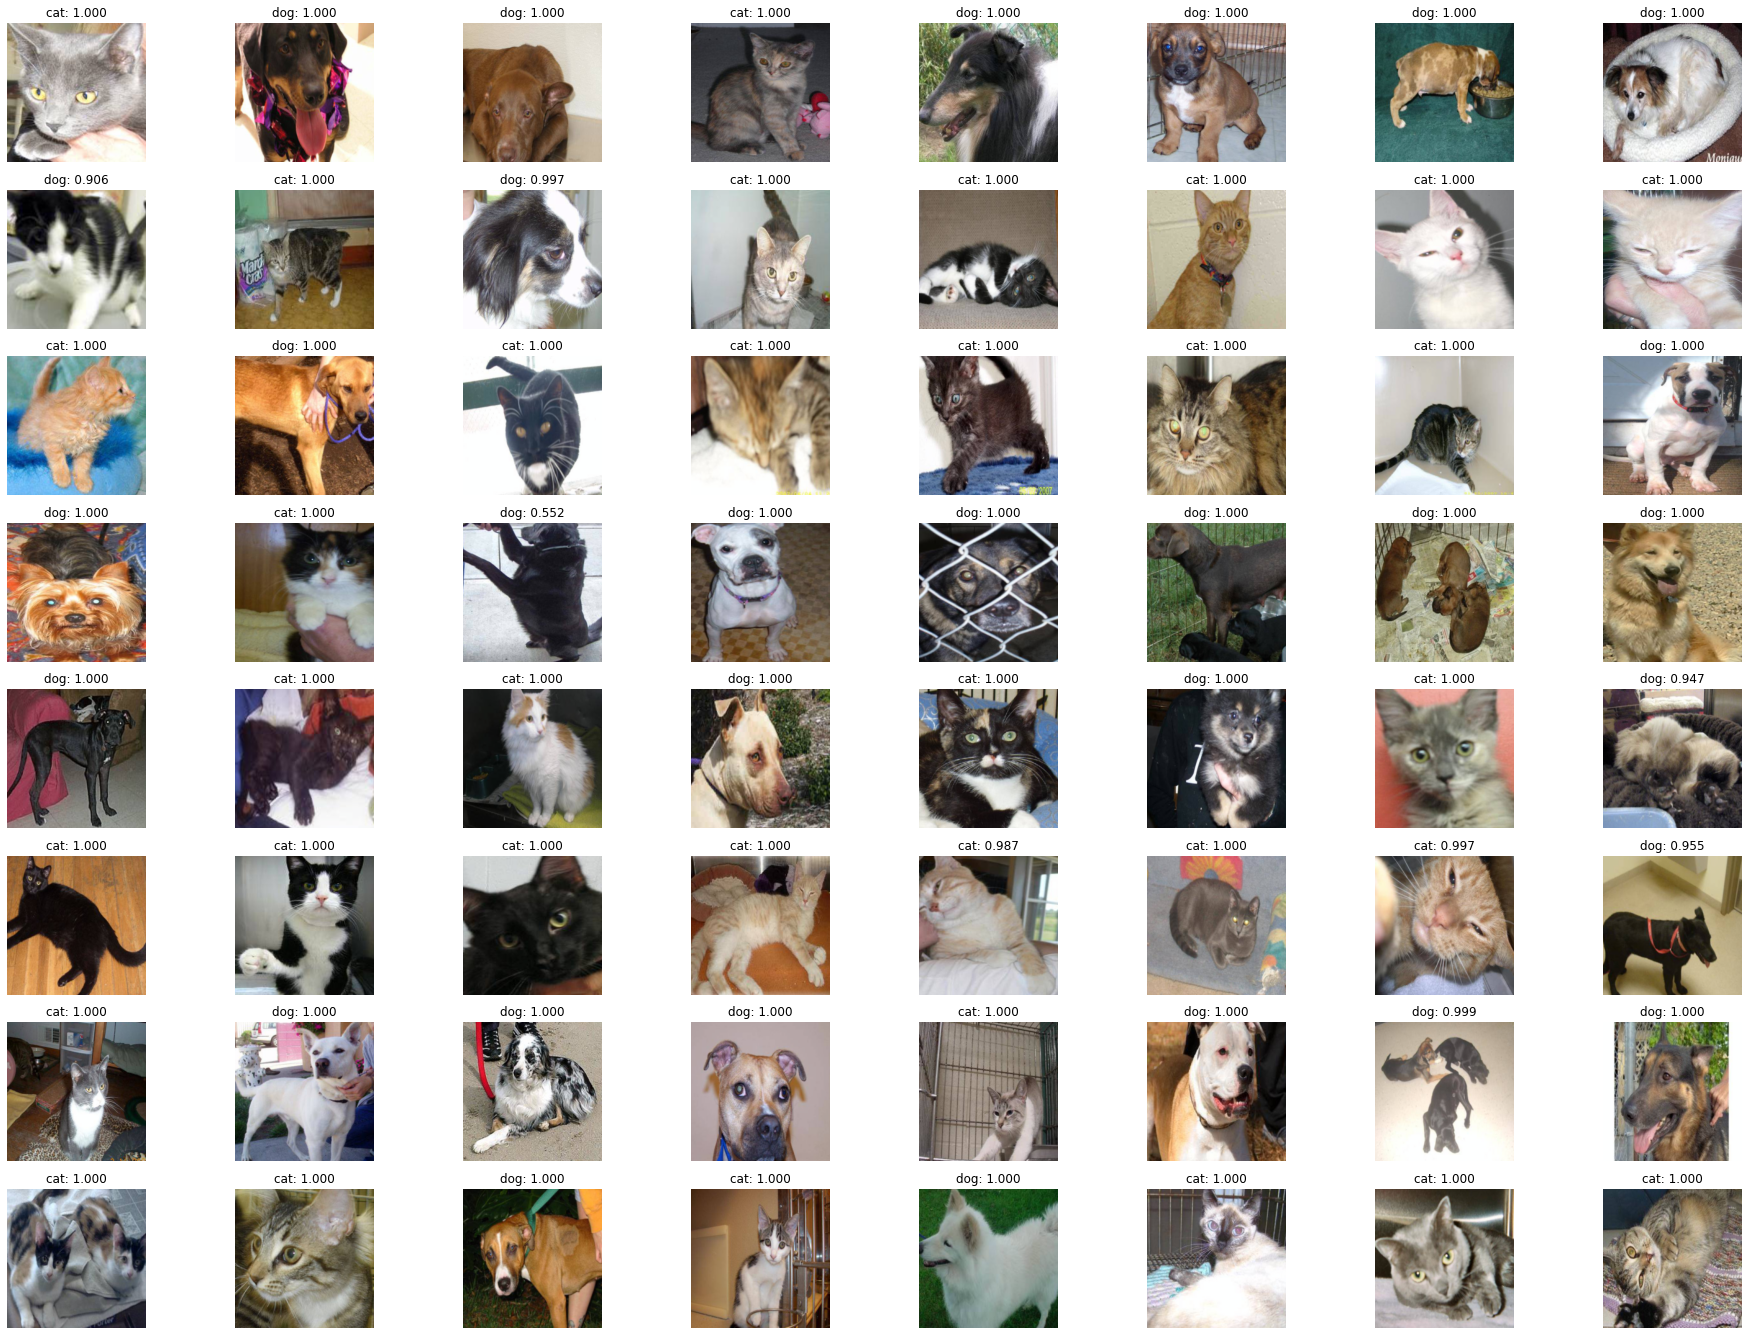

In [9]:
import numpy as np
import torch.nn.functional as F


def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

def visualize_preds(model, device, dataloader, num_images=32):
    class_names = {
        0: 'cat',
        1: 'dog'
    }
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(32,24))
    ncols = 8
    nrows = math.ceil(num_images / ncols)
    
    with torch.no_grad():
        for images, names in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = F.softmax(outputs, 1)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                images_so_far += 1
                ax = plt.subplot(nrows, ncols, images_so_far)
                ax.axis('off')
                idx = preds[i].item()
                ax.set_title('{}: {:.3f}'.format(class_names[idx], outputs[i][idx].item()))
                imshow(images.cpu().data[i])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.savefig('blog4-3.jpg')
                    plt.show()
                    return
        model.train(mode=was_training)
    plt.show()
            

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_set = DogsCatsSet(test_list, test_transform)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True)
visualize_preds(model_ft, device, test_dataloader, 64)

# 保存模型

In [8]:
save_path = 'dogs_vs_cats.pt'
torch.save(model_ft.state_dict(), save_path)